# Goal: apply to your data set

https://github.com/statbiophys/zebrafishGC

In [ ]:
# If not already in your environment, install necessary packages
# !pip install numpy matplotlib scipy 

In [1]:
import math
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import pickle
import time
from scipy.stats import zscore, pearsonr, mannwhitneyu
from random import sample
from common_functions import *
from plotting_functions import * 

In [2]:
# GC parameters

p_val = 0.01 # p-value for the statistical test (will be automatically Bonferroni corrected)
n_lags = 3  # number of lags for GC i.e. number of past time points taken into account


# Load dataset

The calcium traces were extracted from the recordings using suite2p: motion correction has already been done and the data set is exempt of motion artifacts. If you have motion artifacts in your data, you can remove them by interpolating between the previous and next timesteps.

When calcium traces were acquired with a spinning disk microscope, that is using a camera chip for detection of all pixels at once illuminated by a laser, the noise was correlated because all pixels over the field of view were recorded simultaneously. In this case, smoothing the fluorescence traces was consequently necessary. 

In contrast, this step is not advised with two-photon laser scanning microscopy or high speed volumetric light-sheet imaging in which respectively different pixels and planes are scanned across the sample. The hindbrain dataset was recorded with a 2P microscope so we skip the smoothing step. If you need to smooth your signals, the code for total variation regularization is available on the github (matlab code, not implemented in python yet). 

Furthermore, we found that the scanning delay in laser scanning microscopy acquired at 5.81 Hz did not influence the GC results: neurons recorded at the beginning of the scanning cycle did not appear as driver neurons of neurons recorded at the end of the cycle. 

We found however that the drive of a given neuron computed from the naive GC was correlated with the signal-to-noise ratio (SNR) of the calcium trace. Using an adaptive threshold for the significance test, the correlation between the drive and SNR decreased.

In [68]:
# Change if you're using your own data

signals_ori = np.loadtxt('example_HB_calcium_traces.txt') 
n_cells, n_timesteps = signals_ori.shape

with open('xaxes_and_stim.npy', 'rb') as f:
    xAx_calcium = np.load(f)
    xAx_tail = np.load(f)
    xAx_stimulus = np.load(f)
    stim = np.load(f)

with open('background.npy', 'rb') as f:
    background = np.load(f)

with open('cell_centers.npy', 'rb') as f:
    cell_centers = np.load(f)
    
with open('tail_angle.npy', 'rb') as f:
    tail_angle = np.load(f)

frame_rate = 5.81
n_cells = len(cell_centers)  # number of cells
n_pairs = n_cells * (n_cells - 1)


In [ ]:
"""
    Correct one or several motion artifact(s) by nearest point averaging.
"""
# For single time points artifacts you can use this (need to know at which time points)
# idx_MA: an index or a list of indices

signals = correct_motion_artifact(signals, idx_MA)

In [ ]:
""" 
    Select the neurons to use for the GC analysis.
    If your data set is too large take a small subset for the workshop purpose.
"""

# to run on a subset of cells, select neurons of interest (to make it faster)
# cells_subset = np.array([0, 5, 7, 12, 18])

# for all cells change the code or use:
cells_subset = np.arange(n_cells)

n_cells_subset = len(cells_subset)
n_pairs_subset = n_cells_subset* (n_cells_subset-1)

For spontaneous activity (no external stimuli), the shuffling of the data consists of time-shifting the data.
However, if there is a cyclic stimulus, the structure should be conserved and the epochs should be shuffled while
keeping the stimulus fixed (i.e. randomizing the order of the epochs). 

The null F-statistics distribution can be approximated nonparameterically by Monte Carlo reshuffles. However, 
since the significance threshold depends on the tail of the F-statistics distribution, to get an accurate 
estimation requires a large number of reshuffles and is computationally undesirable.

Instead, to accelerate the computation, if the bulk of the Fshuffle distribution is well
approximated by an F-distribution, we can parameterize the null empirical distribution by F(F; α, β), and find the parameters by maximizing the likelihood.

In the hindbrain data set, for each neuron pair (i, j), we noticed that the distribution Fshuffled_i→j was well-described by a constant-rescaled F-distribution. 
Applying an adaptive threshold on Fi→j reduces to applying the original threshold on the normalized F_norm_i→j, defined by dividing the naive F-statistics with the expectation value of the F-statistics generated by the shuffled data. Mathematically,

F_norm_i→j = Fi→j / ⟨Fshuffled_i→j ⟩.

In [69]:
# Optional
"""
    For the shuffling of the data, we need to keep the stimulus structure to increase the specificity and shuffle
    the epochs. These arrays are used to select the time steps of stimulus cycles (and for plotting).
    To be coherent, we only keep complete epochs to have the same number of timesteps between original and shuffled GC.
"""
# Need to be customized to own data
# Ignore for spontaneous activity.



# only if you have a (cyclic) stimulus
stim_duration_ON = 15 # stimulus is on for 15 seconds
stim_duration_OFF = 5 # stimulation is off for 5 seconds

# times in seconds
stim_start_time = xAx_stimulus[np.array([st for st in range(1, len(stim)) if stim[st] > 0 and stim[st-1] == 0])]
stim_end_time = xAx_stimulus[np.array([st for st in range(len(stim)-1) if stim[st] > 0 and stim[st+1] == 0])]

n_epochs = len(stim_start_time) 
len_epoch = stim_start_time[1] - stim_start_time[0] # in seconds

# timesteps in frames
epoch_ts = [round(frame_rate*(stim_duration_OFF+ne*stim_duration_ON)) for ne in range(n_epochs+1)]  # start timestep of stimulus epochs (+ end timestep)
epoch_ts_0 = [ts - epoch_ts[0] for ts in epoch_ts]  # start times of epochs without pre-stim part

# overwrite n_timesteps
n_timesteps = epoch_ts[-1] - epoch_ts[0]  # 1656 timesteps corresponding to the 19 stimulus epochs
                                          # not 1744 that is the length of the whole recording
                                          # we keep 1656 for original GC to be coherent with shuffled GC
        
signals = signals_ori[:, epoch_ts[0]:epoch_ts[-1]]

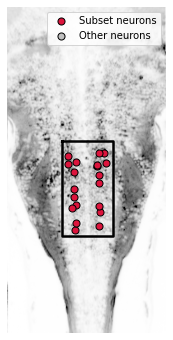

In [80]:
""" 
    The population calcium imaging data was acquired in vivo using a laser scanning two-photon calcium imaging 
    at 5.81 Hz at single-cell resolution of the hindbrain of Tg(elavl3:GCaMP5G) transgenic larvae (previously known 
    as Tg(HUC:GCaMP5G)) during active visuomotor behavior (data from Severi et al. 2018). Medial motor-correlated 
    neurons (V2a stripe, n = 20) in a given plane of the larval zebrafish hindbrain selected for analysis. 
"""

fig, ax = plt.subplots(figsize=(3,6))
plt.imshow(background, cmap=plt.cm.gist_yarg, aspect='equal', vmax=np.max(background)/2)

subset_mask = np.zeros(len(cell_centers), dtype=bool)
subset_mask[cells_subset] = True
subset_centers = cell_centers[subset_mask]

other_mask = np.ones(len(cell_centers), dtype=bool)
other_mask[cells_subset] = False
other_centers = cell_centers[other_mask]

plt.scatter(subset_centers[:,0], 512 - subset_centers[:,1], color='crimson', edgecolor='black', s=50, label='Subset neurons')
plt.scatter(other_centers[:,0], 512 - other_centers[:,1], color='silver', edgecolor='black', s=50, label='Other neurons')

#add legend to plot
plt.legend(fontsize=10)          

# Approximate coordinates of rectangle vertices of the V2A medial stripe
# in clockwise order
xs = [85, 165, 165, 85, 85]
ys = [210, 210, 360, 360, 210]
ax.plot(xs, ys, color="k", linewidth=2.5)

    
plt.tight_layout
plt.axis('off')
plt.show()

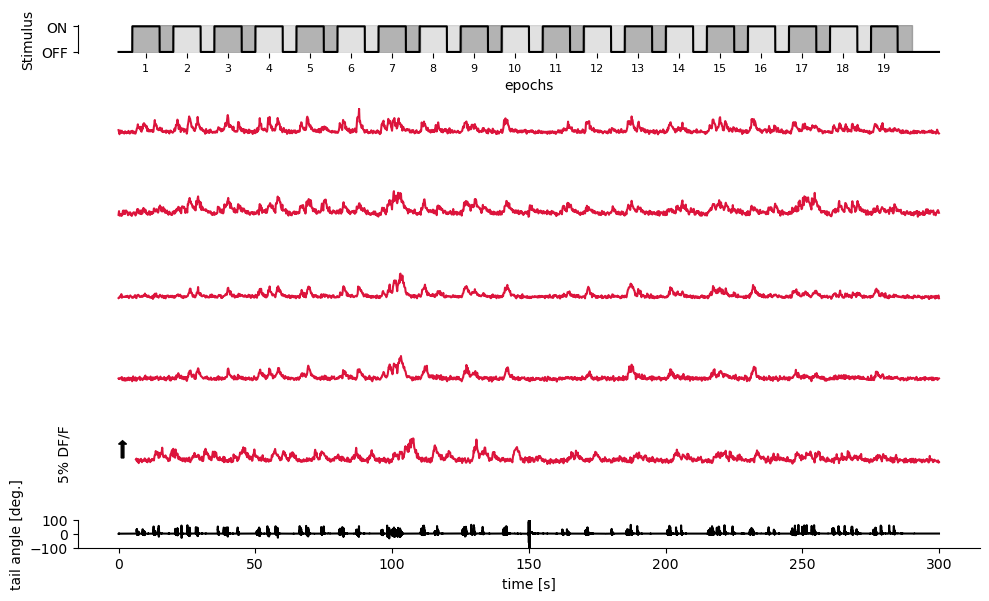

In [256]:
""" 
    Example of calcium traces for the motor-correlated medial neurons.
    The optomotor stimulus is depicted on top while the tail angle illustrating
    The motor output is depicted at the bottom. 
"""

i = 1
fig = plt.figure(figsize=(10,6))
plt.subplot(7,1,i)
plt.plot(xAx_stimulus, stim, color='k')
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
xticklabels = [int(stim_start_time[i]+(stim_end_time[0]-stim_start_time[0])/2) for i in range(len(stim_start_time))]
plt.xticks(xticklabels, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'], fontsize=8)
plt.xlabel('epochs', fontsize=10)
# plt.xlim([-8,300])
plt.yticks([np.min(stim), np.max(stim)], ['OFF', 'ON'], size=10)
plt.ylabel('Stimulus', size=10)


for st in range(len(stim_start_time[::2])):
    plt.axvspan(stim_start_time[2*st], stim_start_time[2*st]+len_epoch, color='dimgray', alpha=0.5)
    if st != len(stim_start_time[::2])-1:
        plt.axvspan(stim_start_time[2*st+1], stim_start_time[2*st+1]+len_epoch, color='dimgray', alpha=0.2)

i = i+1

for n in cells_subset[:5]:
    plt.subplot(7,1,i)
    plt.plot(xAx_calcium, signals_ori[n], label=f'neuron {n}', color='crimson')
#     plt.ylim([-2,6])
#     plt.xlim([-8,300])
    plt.axis('off')
    i = i+1
    
plt.axis('on')
plt.xticks([])
ax = fig.axes[i-2]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.arrow(-5, 0, 0, 5, width=1, head_length=1, head_width=3, color='k', length_includes_head=True)
plt.ylabel('5% DF/F ', size=10)
plt.yticks([])    

plt.subplot(7,1,i)
plt.plot(xAx_tail, tail_angle, color='k')        
plt.tight_layout()
plt.xlabel('time [s]', size=10)
plt.ylabel('tail angle [deg.]', size=10)
plt.xticks(size=10)
# plt.yticks([-100, 0, 100], size=10)
plt.ylim([-100, 100])
#.get_yaxis().set_visible(False)
ax = fig.axes[-1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout() 
plt.show()



### BVGC

In [258]:
"""
    Run the original bivariate GC on fluorescence traces.
"""


# If you replace by your own signals, make sure 'signals' is a np array of shape [n_cells, n_timesteps].
# The length should be the same for all neurons.

dfn = n_lags
dfd_BV = n_timesteps - 3 * n_lags - 1  # 3 because 2 cells involved + 1 constant

# original threshold
threshold_F_ori = stats.f.ppf(1 - p_val/n_pairs_subset, dfn, dfd_BV) # Bonferroni corrected, common for all pairs


# original GC analysis 
gc_sig, gc, fstat, thresh_F = bivariateGC(signals[cells_subset], n_lags=n_lags)

In [75]:
"""
    Shuffle the driving neuron's trace nmc times to generate a new null hypothesis for testing whether
    a link is significant or not.
"""

# My laptop is really slow (5 years old, poor memory)
# 5 neurons & nmc=100 --> 78 seconds
# 20 neurons & nmc=10 --> 3 min
# 20 neurons & nmc=100 --> 13 min

# New BVGC

tic = time.time()


"""
Using the function 'bivariateGC' is much faster (0.32s for 20 neurons vs 6.23s) than doing:

for i, neuron1 in enumerate(cells_subset):
    for j, neuron2 in enumerate(cells_subset):
        if i != j: 
            signal1 = signals[neuron1][epoch_ts[0]:epoch_ts[-1]]  
            signal2 = signals[neuron2][epoch_ts[0]:epoch_ts[-1]]
            
            _, GC, Fstat, _ = bvgc_2_signals(signal1, signal2, n_lags=n_lags, pval=p_val)
            
            
If you don't have time, you may shuffle all signals and call bivariateGC(signals_shuffled),
but this will be too permissive and you will still obtain spurious links.
"""

# number of random shuffles - 100 seems enough (the more the better - 1000 in the paper). 
nmc = 10

all_gcs_sh = np.zeros([n_cells_subset, n_cells_subset, nmc])  # GC matrices for each shuffle
all_fstats_sh = np.zeros([n_cells_subset, n_cells_subset, nmc])  # Fstat matrices for each shuffle

for i, neuron1 in enumerate(cells_subset):
    for j, neuron2 in enumerate(cells_subset):
        if i != j: 
            signal2 = signals[neuron2] # neuron 2 signal, the receiving neuron - unchanged
            
            # Shuffle the signal of neuron 1, the driving neuron
            # Do that nmc times
            # Always maintaining the structure of stimulus epochs
            # If there is no stimulus, you can simply shift the array by different random numer of timesteps 
            for n in range(nmc):
                signal1_sh = shuffle_signal(signals[neuron1], epoch_ts_0)  # shuffle driving signal according to stimulus
                # signal1_sh = shift_signal(signals[neuron1]) # shift the driving signal from a random number of timesteps
                _, GC, Fstat, _ = bvgc_2_signals(signal1_sh, signal2, n_lags=n_lags, pval=p_val)

                all_gcs_sh[i][j][n] = GC
                all_fstats_sh[i][j][n] = Fstat
        else:
            for n in range(nmc):
                all_gcs_sh[i][j][n] = np.nan
                all_fstats_sh[i][j][n] = np.nan


print('running took', time.time() - tic, 'seconds')

running took 771.6108400821686 seconds


C:\Users\faust\AppData\Local\Temp/ipykernel_24308/1683560572.py:89: RuntimeWarning: Mean of empty slice
  mean_F_sh = np.nanmean(all_fstats_sh, axis=2)


C:\Users\faust\AppData\Local\Temp/ipykernel_24308/3340802882.py:6: RuntimeWarning: Mean of empty slice
  mean_F_sh = np.nanmean(all_fstats_sh, axis=2)


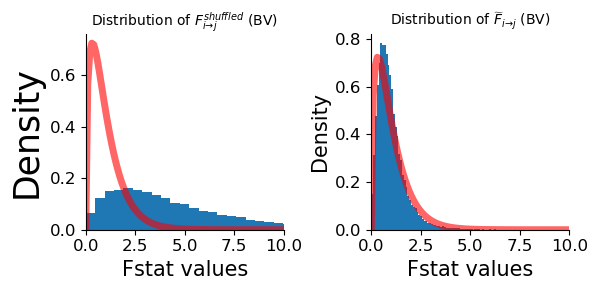

In [269]:
"""
    Check if you can approximate F-shuffled by a constant-rescaled F-distribution 
    (divided by the mean of F-shuffled, for each pair).
"""

mean_F_sh = np.nanmean(all_fstats_sh, axis=2)

dfn = n_lags
dfd_BV = n_timesteps - 3 * n_lags - 1  # 2 cells involved + 1

nmc = all_fstats_sh.shape[-1]
all_fstats_sh_rescaled = np.zeros((n_cells_subset, n_cells_subset, nmc))

for i in range(n_cells_subset):
    for j in range(n_cells_subset):
        if i != j:
            for k in range(nmc):
                all_fstats_sh_rescaled[i,j,k] = all_fstats_sh[i,j,k] / mean_F_sh[i,j]


# before rescaling
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.hist(all_fstats_sh.flatten()[all_fstats_sh.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $F_{i \to j}^{shuffled}$ (BV)', size=10)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_BV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=25)
plt.xlabel('Fstat values', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(122)
plt.hist(all_fstats_sh_rescaled.flatten()[all_fstats_sh_rescaled.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $\widetilde{F}_{i\to j}$ (BV)', size=10)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_BV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=15)
plt.xlabel('Fstat values', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
""" If previously rescaled distribution looks like F-distribution. """

# # rescale (done before)
# mean_F_sh = np.nanmean(all_fstats_sh, axis=2)
# all_fstats_sh_rescaled = np.zeros([n_cells_subset, n_cells_subset, nmc])

# for i in range(n_cells_subset):
#     for j in range(n_cells_subset):
#         if i != j:
#             for k in range(nmc):
#                 all_fstats_sh_rescaled[i,j,k] = all_fstats_sh[i,j,k] / mean_F_sh[i,j] # follows F distribution
#         else:
#             for k in range(nmc):
#                 all_fstats_sh_rescaled[i,j,k] = np.nan

# we noticed that the distribution of Fstats on shuffled signals is well-described by a constant-rescaled F-distribution
# this might not be true for your data.
# if it looks like a shifted F-distribution, you can fit the correct parameter by maximizing the likelihood.
threshold_F_new = mean_F_sh * threshold_F_ori  # customized threshold
fstat_normalized = fstat / mean_F_sh

# For hindbrain medial neurons:
t_regr = n_timesteps - n_lags # = 1653 because 1656 timesteps taken not 1744
#     BVGC
#         dof_full = 2 * n_lags = 6
#         dof_reduced = n_lags = 3
#     MVGC
#         dof_full = n_rois * n_lags = 60
#         dof_reduced = (n_rois - 1) * n_lags = 57

# compute new gc
gc_normalized = get_GC_from_Fstat(fstat_normalized, 2*n_lags, n_lags, t_regr) # normalized GC

In [239]:
""" 
    If previously rescaled distribution does not look like F-distribution. 
    
    To improve specificity, we define the null expectation as the distribution for the F-statistics of the cyclically
    shuffled data to test for the significance of GC links. A GC link from the data is significant, if it has an
    F-statistics that is above the 1−p percentile of the null F-statistics distribution, generated from the cyclically
    shuffled data. The null F-statistics distribution can be approximated non-parameterically by Monte Carlo reshuffles. 
    However, since the significance threshold depends on the tail of the F-statistics distribution, to get an accurate
    estimation requires a large number of reshuffles and is computationally undesirable.
    
    Instead, to accelerate the computation, if the bulk of the Fshuffle distribution is well approximated by an 
    F-distribution (with possible outliers e.g. for the motoneuron data set they are explained by the pseudo-periodicity 
    of the data). We parameterize the null empirical distribution by F(F;α,β), and find the parameters by maximizing 
    the likelihood. 
"""
# # Exclude outliers in all_fstats_sh - e.g. if pseudo-periodicity in the data
# outlier_threshold = 20 
# afs = all_fstats_sh[all_fstats_sh>0]
# afs = afs[afs<outlier_threshold]


# log_likelihood_list = []

# dfds = np.arange(1, 21) 

# for dfd_to_fit in dfds:
#     log_like = 0
#     for a in afs:
#         log_like = log_like + np.log(stats.f.pdf(a, n_lags, dfd_to_fit))
            
#     log_like = log_like / len(afs)
#     log_likelihood_list.append(log_like)
    
# dfd_new = dfds[np.argmax(log_likelihood_list)]

# threshold_F_new2 = stats.f.ppf(1 - p_val/n_pairs_subset, dfn, dfd_new)

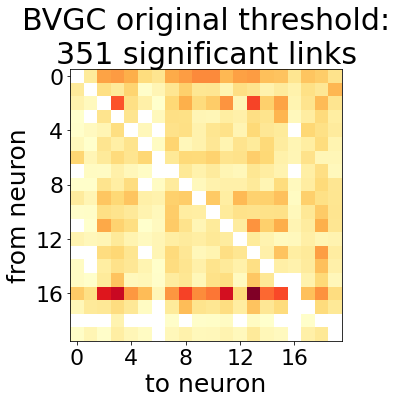

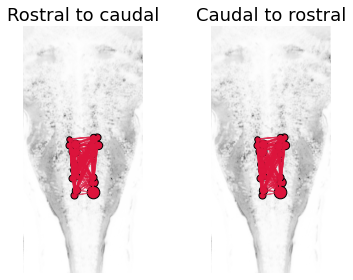

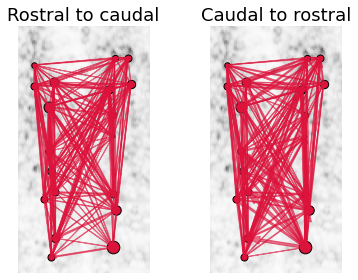

In [76]:
"""
    GC matrix and map of information flow for the naive BVGC on medial motor-correlated neurons. 351 out of 380
    possible pairs are found to have a significant drive. This almost fully-connected network suggests that the naive 
    BVGC algorithm is too permissive to false positive links, and an adapted pipeline is needed to clean out the
    many spurious connections.
"""

gc_sig_original = get_GC_sig(gc, fstat, threshold_F_ori) # or simply gc_sig

plt.figure(figsize=(5,5))
n_sig = len([i  for j in gc_sig_original for i in j if i>0])
plt.imshow(gc_sig_original, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'BVGC original threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,n_cells_subset,4), size=22) 
plt.yticks(np.arange(0,n_cells_subset,4), size=22) 
plt.show()

# If you have the background
plot_info_flow_HB(gc_sig_original, cell_centers[cells_subset], background, zoom=False, cst=100/n_cells_subset) # for your own data add do_invert=False
plt.tight_layout()
plt.show()

# if you're using your own data set change the x and y axes limits
plot_info_flow_HB(gc_sig_original, cell_centers[cells_subset], background, zoom=True, xlims=[85,165], ylims=[360, 210], cst=100/n_cells_subset)  # for your own data add do_invert=False
plt.tight_layout()
plt.show()

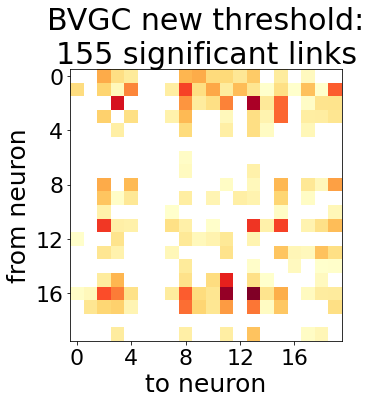

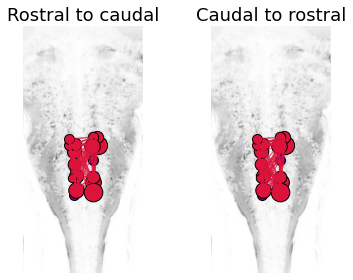

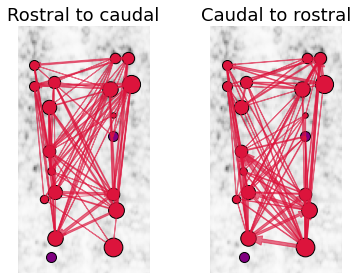

In [77]:
"""
    After we customized the threshold and normalized the GC values, we obtain a network with fewer remaining 
    significant GC link
"""

gc_sig_new = get_GC_sig(gc_normalized, fstat, threshold_F_new)

plt.figure(figsize=(5,5))
n_sig = len([i  for j in gc_sig_new for i in j if i>0])
plt.imshow(gc_sig_new, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'BVGC new threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,n_cells_subset,4), size=22) 
plt.yticks(np.arange(0,n_cells_subset,4), size=22) 
plt.show()

# If you have the background
plot_info_flow_HB(gc_sig_new, cell_centers[cells_subset], background, zoom=False)  # for your own data add do_invert=False
plt.tight_layout()
plt.show()

# if you're using your own data set change the x and y axes limits
plot_info_flow_HB(gc_sig_new, cell_centers[cells_subset], background, zoom=True, xlims=[85,165], ylims=[360,210])  # for your own data add do_invert=False
plt.tight_layout()
plt.show()

### MVGC

In [ ]:
"""
    Run the original multivariate GC on fluorescence traces.
"""

# to run on a subset of cells, select neurons of interest
cells_subset = np.array([0, 5, 7, 12, 18])
# for all cells change the code or use:
cells_subset = np.arange(n_cells)
n_cells_subset = len(cells_subset)
n_pairs_subset = n_cells_subset* (n_cells_subset-1)



# If you replace by your own signals, make sure 'signals' is a np array of shape [n_cells, n_timesteps].
# The length should be the same for all neurons.

dfn = n_lags  # same as for BVGC
dfd_MV = n_timesteps - (n_cells_subset + 1) * n_lags - 1  # n_cells involved +1

MV_threshold_F_ori = stats.f.ppf(1 - p_val/n_pairs_subset, dfn, dfd_MV) # Bonferroni corrected, common for all pairs

# original GC analysis on original signals
# only use 1656 timesteps to match the length of shuffled data (according to stimulus)
MV_gc_sig , MV_gc, MV_fstat, MV_thresh_F = multivariateGC(signals[cells_subset], n_lags=n_lags)

In [84]:
# My laptop is really slow (5 years old, poor memory)
# 5 neurons & nmc=100 --> ~3 min
# 20 neurons & nmc=10 --> ~13-20 min
# computational cost increases exponentially as you add more neurons


"""
    Shuffle the driving neuron's trace nmc times to generate a new null hypothesis for testing whether
    a link is significant or not. This takes a lot of time (MVGC takes much more time than BVGC if you have
    a lot of neurons), so we recommend running it on a cluster (bash script available on github).
"""

tic = time.time()



"""
Using multivariateGC is much faster (1s for 20 neurons vs 57s) than doing:

for i, neuron1 in enumerate(cells_subset):
    for j, neuron2 in enumerate(cells_subset):
        if i != j: 
            # original GC analysis on original signals
            # only use 1656 timesteps to match length of shuffled data 
            signal1 = signals[neuron1] 
            signal2 = signals[neuron2]
            
            small = min(i, j)
            large = max(i, j)
            z_indices = np.r_[0:small, small + 1:large, large + 1:n_cells_subset]
            # OR z_indices = [k for k in range(n_cells_subset) if k not in [i, j]]
            Z_set = signals[cells_subset[z_indices]]
                       
            _, GC, Fstat, _ = mvgc_2_signals(signal1, signal2, Z_set, n_lags=n_lags, pval=p_val)
            MV_gc[i][j] = GC
            MV_fstat[i][j] = Fstat
            
If you don't have time, you may shuffle all signals and call multivariateGC(signals_shuffled),
but this will be too permissive and you will still obtain spurious links.
"""

# number of random shuffles - 100 should be enough.
nmc = 10 

MV_all_gcs_sh = np.zeros([n_cells_subset, n_cells_subset, nmc])  # GC matrices for each shuffle
MV_all_fstats_sh = np.zeros([n_cells_subset, n_cells_subset, nmc])  # Fstats matrices for each shuffle

for i, neuron1 in enumerate(cells_subset):
    for j, neuron2 in enumerate(cells_subset):
        if i != j: 
            signal2 = signals[neuron2]
            
            small = min(i, j)
            large = max(i, j)
            z_indices = np.r_[0:small, small + 1:large, large + 1:n_cells_subset] # build conditioning set - here all other neurons
            # OR z_indices = [k for k in range(n_rois) if k not in [i, j]]
            Z_set = signals[cells_subset[z_indices]]
            
            # Shuffle signal1 nmc times            
            for n in range(nmc):
                # MVGC
                signal1_sh = shuffle_signal(signals[neuron1], epoch_ts_0)  # shuffle driving signal
                _, GC, Fstat, _ = mvgc_2_signals(signal1_sh, signal2, Z_set, n_lags=n_lags, pval=p_val)

                MV_all_gcs_sh[i][j][n] = GC
                MV_all_fstats_sh[i][j][n] = Fstat
        else:
            for n in range(nmc):
                MV_all_gcs_sh[i][j][n] = np.nan
                MV_all_fstats_sh[i][j][n] = np.nan


print('running took', time.time() - tic, 'seconds')

running took 1445.8145968914032 seconds


C:\Users\faust\AppData\Local\Temp/ipykernel_24308/883915147.py:92: RuntimeWarning: Mean of empty slice
  MV_mean_F_sh = np.nanmean(MV_all_fstats_sh, axis=2)


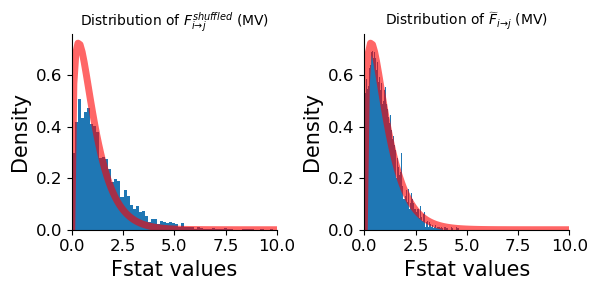

In [268]:
"""
    Check if you can approximate F-shuffled by a constant-rescaled F-distribution 
    (divided by the mean of F-shuffled, for each pair).
"""

# rescale
MV_mean_F_sh = np.nanmean(MV_all_fstats_sh, axis=2)
MV_all_fstats_sh_rescaled = np.zeros([n_cells_subset, n_cells_subset, nmc])

for i in range(n_cells_subset):
    for j in range(n_cells_subset):
        if i != j:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = MV_all_fstats_sh[i,j,k] / MV_mean_F_sh[i,j] # follows F distribution
        else:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = np.nan




# before rescaling
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.hist(MV_all_fstats_sh.flatten()[MV_all_fstats_sh.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $F_{i \to j}^{shuffled}$ (MV)', size=10)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_MV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=15)
plt.xlabel('Fstat values', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# rescaled
plt.subplot(122)
plt.hist(MV_all_fstats_sh_rescaled.flatten()[MV_all_fstats_sh_rescaled.flatten()>0], density = True, bins=100)
plt.title(r'Distribution of $\widetilde{F}_{i\to j}$ (MV)', size=10)
x = np.linspace(0, 10, 100)
plt.plot(x, stats.f.pdf(x, dfn, dfd_MV), 'r-', lw=5, alpha=0.6, label='f pdf')
plt.xlim([0, 10])
plt.ylabel('Density', size=15)
plt.xlabel('Fstat values', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
""" If previously rescaled distribution looks like F-distribution. """

# # rescale (done before)
MV_mean_F_sh = np.nanmean(MV_all_fstats_sh, axis=2)
MV_all_fstats_sh_rescaled = np.zeros([n_cells_subset, n_cells_subset, nmc])

for i in range(n_cells_subset):
    for j in range(n_cells_subset):
        if i != j:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = MV_all_fstats_sh[i,j,k] / MV_mean_F_sh[i,j] # follows F distribution
        else:
            for k in range(nmc):
                MV_all_fstats_sh_rescaled[i,j,k] = np.nan
                
                # customized threshold
MV_threshold_F_new = MV_mean_F_sh * MV_threshold_F_ori
MV_fstat_normalized = MV_fstat / MV_mean_F_sh

# For hindbrain:
t_regr = n_timesteps - n_lags # = 1653 because 1656 timesteps taken not 1744
    
MV_gc_normalized = get_GC_from_Fstat(MV_fstat_normalized, (n_cells_subset - 1)*n_lags, n_lags, t_regr) # normalized GC



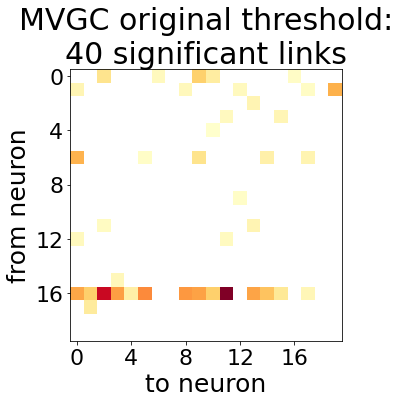

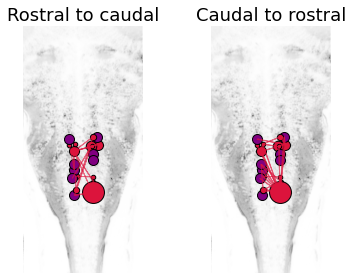

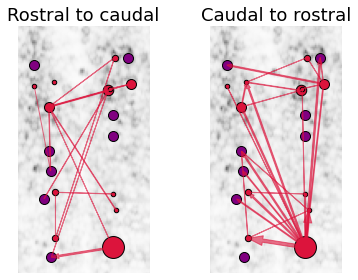

In [85]:
MV_gc_sig_original = get_GC_sig(MV_gc, MV_fstat, MV_threshold_F_ori) # or simply MV_gc_sig

plt.figure(figsize=(5,5))
n_sig = len([i  for j in MV_gc_sig_original for i in j if i>0])
plt.imshow(MV_gc_sig_original, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'MVGC original threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,n_cells_subset,4), size=22) 
plt.yticks(np.arange(0,n_cells_subset,4), size=22) 
plt.show()

# If you have the background
plot_info_flow_HB(MV_gc_sig_original, cell_centers[cells_subset], background, zoom=False)
plt.tight_layout()
plt.show()

# if you're using your own data set change the x and y axes limits
plot_info_flow_HB(MV_gc_sig_original, cell_centers[cells_subset], background, zoom=True, xlims=[85,165], ylims=[360, 210]) 
plt.tight_layout()
plt.show()

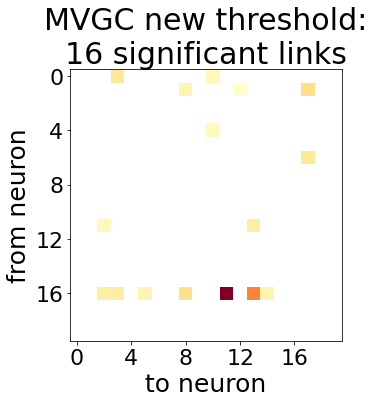

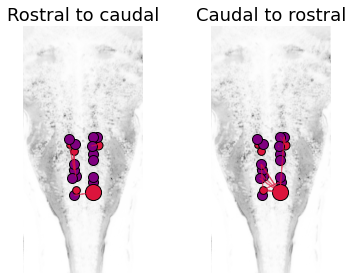

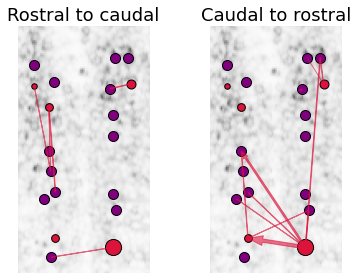

In [87]:
"""
    The pipeline applied to MVGC removes too many links due to the high correlation in the data (all neurons 
    are motor-correlated) and relatively high number of neurons (20).
"""


MV_gc_normalized_sig_new = get_GC_sig(MV_gc_normalized, MV_fstat, MV_threshold_F_new)

plt.figure(figsize=(5,5))
n_sig = len([i  for j in MV_gc_normalized_sig_new for i in j if i>0])
plt.imshow(MV_gc_normalized_sig_new, cmap='YlOrRd')
plt.xlabel("to neuron", size=25)
plt.ylabel("from neuron", size=25)
plt.title(f'MVGC new threshold:\n{n_sig} significant links', size=30)
plt.xticks(np.arange(0,n_cells_subset,4), size=22) 
plt.yticks(np.arange(0,n_cells_subset,4), size=22) 
plt.show()

plot_info_flow_HB(MV_gc_normalized_sig_new, cell_centers[cells_subset], background, cst=10)
plt.tight_layout()
plt.show()

# if you're using your own data set change the x and y axes limits
plot_info_flow_HB(MV_gc_normalized_sig_new, cell_centers[cells_subset], background, zoom=True, xlims=[85,165], ylims=[360, 210], cst=10)
plt.tight_layout()
plt.show()

### GC links' angles analysis


C:\Users\faust\AppData\Local\Temp/ipykernel_24308/966724033.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axY.set_xticklabels(['180', '', '-90°', '', '0°', '', '90°', ''])


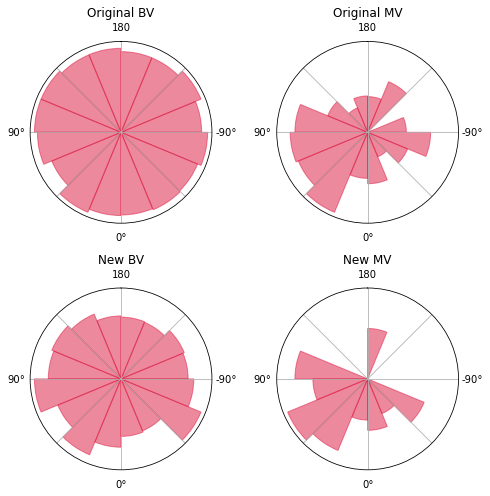

In [108]:
"""
    GC link orientations. Polar histograms of the proportion of angles of significant GC links over all 
    possible GC link. The obtained GC links angles suggest an information flow from the right to the left hindbrain, 
    which could be consistent with the presence of the stimulus on the right side of the fish. This was consistent
    across the medial swim-correlated neurons, on all swim-correlated neurons of all planes of fish 6 (11 planes, 
    176 neurons in total, and on all swim-correlated neurons of all planes of all fish (10 fish, 975 neurons in total).
"""

# plt.style.use('seaborn')


bv_phis = get_phi(gc_sig_original, cell_centers[cells_subset])
bv_phis_new = get_phi(gc_sig_new, cell_centers[cells_subset])
mv_phis = get_phi(MV_gc_sig_original, cell_centers[cells_subset])
mv_phis_new = get_phi(MV_gc_normalized_sig_new, cell_centers[cells_subset])

gc_null = np.ones((n_cells_subset, n_cells_subset))
np.fill_diagonal(gc_null, 0)
phis_null = get_phi(gc_null, cell_centers[cells_subset])      


bins = np.arange(-np.pi, 9*np.pi/8, np.pi/8)

fig, ax = plt.subplots(2,2, figsize=(7,7), subplot_kw=dict(projection='polar'))

n_null, _ =  np.histogram(np.array(phis_null), bins=bins)

n, _ = np.histogram(np.array(bv_phis), bins=bins)
n_prop = np.divide(n, n_null, out=np.zeros(n.shape), where=n_null!=0)
circular_hist_from_n_and_bins(ax[0, 0], n_prop, bins, density=True, offset=0, gaps=False, fill=True, alpha=0.5, color='crimson')
ax[0, 0].set_title('Original BV')

n, _ = np.histogram(np.array(bv_phis_new), bins=bins)
n_prop = np.divide(n, n_null, out=np.zeros(n.shape), where=n_null!=0)
circular_hist_from_n_and_bins(ax[1, 0], n_prop, bins, density=True, offset=0, gaps=False, fill=True, alpha=0.5, color='crimson')
ax[1, 0].set_title('New BV')

n, _ = np.histogram(np.array(mv_phis), bins=bins)
n_prop = np.divide(n, n_null, out=np.zeros(n.shape), where=n_null!=0)
circular_hist_from_n_and_bins(ax[0, 1], n_prop, bins, density=True, offset=0, gaps=False, fill=True, alpha=0.5, color='crimson')
ax[0, 1].set_title('Original MV')

n, _ = np.histogram(np.array(mv_phis_new), bins=bins)
n_prop = np.divide(n, n_null, out=np.zeros(n.shape), where=n_null!=0)
circular_hist_from_n_and_bins(ax[1, 1], n_prop, bins, density=True, offset=0, gaps=False, fill=True, alpha=0.5, color='crimson')
ax[1, 1].set_title('New MV')

# ax[0, 0].legend()
# ax[0, 1].legend()
# ax[0, 2].legend()
# ax[0, 3].legend()

for axX in ax:
    for axY in axX:
        axY.set_xticklabels(['180', '', '-90°', '', '0°', '', '90°', ''])
    
plt.tight_layout()
plt.show()


# 0 = top of fish

### Tail angle analysis
Need extra data

C:\Users\faust\AppData\Local\Temp/ipykernel_24308/3390349085.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['', '-45°', '0°', '45°', ''])
C:\Users\faust\AppData\Local\Temp/ipykernel_24308/3390349085.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['180', '', '-90°', '', '0°', '', '90°', ''])


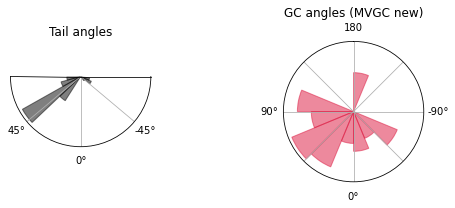

In [124]:
""" 
    Comparison of the distribution of the tail angles of turns (angles where 45 < |a| < 90), to the distribution
    of GC links angles and found that both seem biased to go towards the left. Across the a group of strong driver 
    neurons which could correspond to the right Mesencephalic Locomotor Region (MLR, orange square in paper). 
    This is consistent with the wave of activation starting from the right retina (when a stimulus is presented to the right), then propagating contralaterally to 
    the left tectum, which in turn could transmit information contralaterally to the right MLR.
"""

# plt.style.use('seaborn')

angle_min = 45
angle_max = 90

n_bins_tail = 12

fig, ax = plt.subplots(1,2, figsize=(8, 3), subplot_kw=dict(projection='polar'))


turn_tail_angle = tail_angle[((tail_angle < -angle_min) & (tail_angle > -angle_max)) | ((tail_angle > angle_min) & (tail_angle < angle_max))] # remove forward
turn_tail_angle = turn_tail_angle * np.pi / 180 # convert to radians

n_tail, bins_tail = np.histogram(turn_tail_angle, bins=n_bins_tail)
circular_hist_from_n_and_bins(ax[0], n_tail, bins_tail, density=True, offset=np.pi, clockwise=True, gaps=False, fill=True, alpha=0.5, color='black', label='tail angle')
ax[0].set_title(f'Tail angles')
ax[0].set_xticklabels(['', '-45°', '0°', '45°', ''])
ax[0].set_thetamin(-90)
ax[0].set_thetamax(90)


gc_null = np.ones((n_cells_subset, n_cells_subset))
np.fill_diagonal(gc_null, 0)
phis_null = get_phi(gc_null, cell_centers[cells_subset])    
n_null, _ = np.histogram(np.array(phis_null), bins=bins)

n, _ = np.histogram(np.array(mv_phis_new), bins=bins)
n_prop = np.divide(n, n_null, out=np.ones(n.shape), where=n_null!=0)
circular_hist_from_n_and_bins(ax[1], n_prop, bins, density=True, offset=0, gaps=False, fill=True, alpha=0.5, color='crimson')

ax[1].set_xticklabels(['180', '', '-90°', '', '0°', '', '90°', ''])
ax[1].set_title(f'GC angles (MVGC new)')
plt.tight_layout()
plt.show()

### Computing the new threshold

### Maximum lag choice

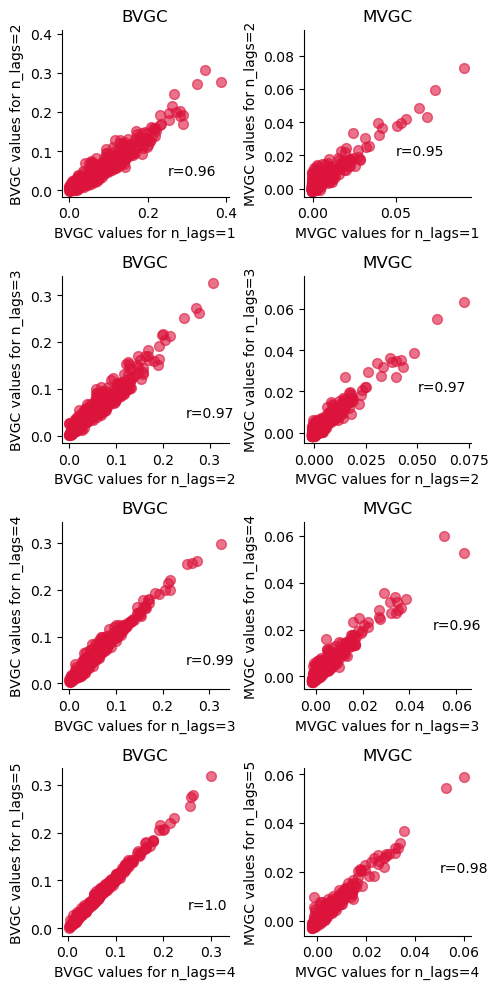

In [147]:
# Compute GC for different number of lags
# Compare correlation of GC results for different lags


# gc_sig_1, gc_1, fstat_1, threshold_F_1 = bivariateGC(signals, n_lags=1)
# gc_sig_2, gc_2, fstat_2, threshold_F_2 = bivariateGC(signals, n_lags=2)
# gc_sig_4, gc_4, fstat_4, threshold_F_4 = bivariateGC(signals, n_lags=4)
# gc_sig_5, gc_5, fstat_5, threshold_F_5 = bivariateGC(signals, n_lags=5)

# mv_gc_sig_1, mv_gc_1, mv_fstat_1, mv_threshold_F_1 = multivariateGC(signals, n_lags=1)
# mv_gc_sig_2, mv_gc_2, mv_fstat_2, mv_threshold_F_2 = multivariateGC(signals, n_lags=2)
# mv_gc_sig_4, mv_gc_4, mv_fstat_4, mv_threshold_F_4 = multivariateGC(signals, n_lags=4)
# mv_gc_sig_5, mv_gc_5, mv_fstat_5, mv_threshold_F_5 = multivariateGC(signals, n_lags=5)

ticksize=15

plt.style.use('default')
plt.figure(figsize=(5,10))

plt.subplot(421)
plt.scatter(gc_1.flatten(), gc_2.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = gc_1.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = gc_2.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("BVGC values for n_lags=1", size=10)
plt.ylabel("BVGC values for n_lags=2", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.25, 0.04, f'r={np.round(cor,2)}', fontsize=10)
plt.title('BVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(422)
plt.scatter(mv_gc_1.flatten(), mv_gc_2.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = mv_gc_1.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = mv_gc_2.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("MVGC values for n_lags=1", size=10)
plt.ylabel("MVGC values for n_lags=2", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.05, 0.02, f'r={np.round(cor,2)}', fontsize=10)
plt.title('MVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(423)
plt.scatter(gc_2.flatten(), gc.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = gc_2.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = gc.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("BVGC values for n_lags=2", size=10)
plt.ylabel("BVGC values for n_lags=3", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.25, 0.04, f'r={np.round(cor,2)}', fontsize=10)
plt.title('BVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(424)
plt.scatter(mv_gc_2.flatten(), MV_gc.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = mv_gc_2.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = MV_gc.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("MVGC values for n_lags=2", size=10)
plt.ylabel("MVGC values for n_lags=3", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.05, 0.02, f'r={np.round(cor,2)}', fontsize=10)
plt.title('MVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(425)
plt.scatter(gc.flatten(), gc_4.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = gc.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = gc_4.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("BVGC values for n_lags=3", size=10)
plt.ylabel("BVGC values for n_lags=4", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.25, 0.04, f'r={np.round(cor,2)}', fontsize=10)
plt.title('BVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(426)
plt.scatter(MV_gc.flatten(), mv_gc_4.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = MV_gc.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = mv_gc_4.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("MVGC values for n_lags=3", size=10)
plt.ylabel("MVGC values for n_lags=4", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.05, 0.02, f'r={np.round(cor,2)}', fontsize=10)
plt.title('MVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(427)
plt.scatter(gc_4.flatten(), gc_5.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = gc_4.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = gc_5.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("BVGC values for n_lags=4", size=10)
plt.ylabel("BVGC values for n_lags=5", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.25, 0.04, f'r={np.round(cor,2)}', fontsize=10)
plt.title('BVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(428)
plt.scatter(mv_gc_4.flatten(), mv_gc_5.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = mv_gc_4.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = mv_gc_5.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("MVGC values for n_lags=4", size=10)
plt.ylabel("MVGC values for n_lags=5", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.05, 0.02, f'r={np.round(cor,2)}', fontsize=10)
plt.title('MVGC', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()



### Do we have enough time points to run GC?

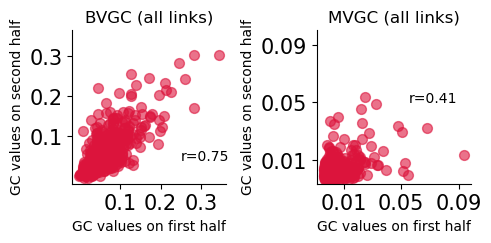

In [257]:
# gc_sig_1_1, gc_1_1, fstat_1_1, threshold_F_1_1 = bivariateGC(signals_ori[:, :872], n_lags=3)
# gc_sig_1_2, gc_1_2, fstat_1_2, threshold_F_1_2 = bivariateGC(signals_ori[:, 872:], n_lags=3)

# mv_gc_sig_1_1, mv_gc_1_1, mv_fstat_1_1, mv_threshold_F_1_1 = multivariateGC(signals_ori[:, :872], n_lags=3)
# mv_gc_sig_1_2, mv_gc_1_2, mv_fstat_1_2, mv_threshold_F_1_2 = multivariateGC(signals_ori[:, 872:], n_lags=3)

ticksize=15

plt.style.use('default')

plt.figure(figsize=(5,2.5))
label_list = [0.1, 0.2, 0.3]
plt.subplot(121)
plt.scatter(gc_1_1.flatten(), gc_1_2.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = gc_sig_1_1.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = gc_sig_1_2.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("GC values on first half", size=10)
plt.ylabel("GC values on second half", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.25, 0.04, f'r={np.round(cor,2)}', fontsize=10)
plt.xticks(label_list, fontsize=ticksize)
plt.yticks(label_list, fontsize=ticksize)
plt.title('BVGC (all links)', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

label_list = [0.01, 0.05, 0.09]
plt.subplot(122)
plt.scatter(mv_gc_1_1.flatten(), mv_gc_1_2.flatten(), c='crimson' , alpha=0.6, s=50)
plt.axis('square')
gc1 = mv_gc_1_1.flatten()
gc1[np.isnan(gc1)] = 0
gc2 = mv_gc_1_2.flatten()
gc2[np.isnan(gc2)] = 0
plt.xlabel("GC values on first half", size=10)
plt.ylabel("GC values on second half", size=10)
cor = stats.pearsonr(gc1, gc2)[0]
plt.text(0.055, 0.05, f'r={np.round(cor,2)}', fontsize=10)
plt.xticks(label_list, fontsize=ticksize)
plt.yticks(label_list, fontsize=ticksize)
plt.title('MVGC (all links)', size=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

